In [1]:
import torch
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)


c:\Users\Sohan M\anaconda3\envs\pytorch\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


cuda:0


In [2]:

import torchvision
from torch import nn
from torchvision import transforms, datasets
from torch.utils.data import DataLoader
# from torchinfo import summary
from torch.utils import data
import torch.nn.functional as F

import numpy as np
import matplotlib.pyplot as plt


In [3]:
train_dir = "./concrete_cracked_images/train/"
test_dir = "./concrete_cracked_images/test/"

# Setup ImageNet normalization levels (turns all images into similar distribution as ImageNet)
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])

# Create starter transform
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(degrees=90),
    
    transforms.ToTensor(),
    normalize
])

test_transform = transforms.Compose([transforms.Resize((224, 224)),
    transforms.ToTensor(),
    normalize
])           

# Create datasets

train_dataset = torchvision.datasets.ImageFolder(root = train_dir, transform = train_transform)


In [4]:
train_dataset

Dataset ImageFolder
    Number of datapoints: 28718
    Root location: ./concrete_cracked_images/train/
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=None)
               RandomHorizontalFlip(p=0.5)
               RandomRotation(degrees=[-90.0, 90.0], interpolation=nearest, expand=False, fill=0)
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )

In [4]:
test_dataset = torchvision.datasets.ImageFolder(root = test_dir, transform = test_transform)

In [6]:
test_dataset

Dataset ImageFolder
    Number of datapoints: 11282
    Root location: ./concrete_cracked_images/test/
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=None)
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )

In [5]:
train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers= 4)
test_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=False , num_workers=4)
classes = ("negative", "positive")


In [6]:
from torch import conv2d, max_pool2d
from torch.nn import Dropout, Linear
from torch.nn.modules import MaxPool2d, ReLU, linear, padding
from torch.nn.modules.pooling import MaxPool3d


class ResBlock(nn.Module):
    def __init__(self, in_channels, out_channels, downsample):
        super().__init__()
        if downsample:
            self.conv1 = nn.Conv2d(
                in_channels, out_channels, kernel_size=3, stride=2, padding=1)
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=2),
                nn.BatchNorm2d(out_channels)
            )
        else:
            self.conv1 = nn.Conv2d(
                in_channels, out_channels, kernel_size=3, stride=1, padding=1)
            self.shortcut = nn.Sequential()

        self.conv2 = nn.Conv2d(out_channels, out_channels,
                               kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.bn2 = nn.BatchNorm2d(out_channels)

    def forward(self, input):
        shortcut = self.shortcut(input)
        input = nn.ReLU()(self.bn1(self.conv1(input)))
        input = nn.ReLU()(self.bn2(self.conv2(input)))
        input = input + shortcut
        return nn.ReLU()(input)
    

        


In [7]:
class ResBottleneckBlock(nn.Module):
    def __init__(self, in_channels, out_channels, downsample):
        super().__init__()
        self.downsample = downsample
        self.conv1 = nn.Conv2d(in_channels, out_channels//4,
                               kernel_size=1, stride=1)
        self.conv2 = nn.Conv2d(
            out_channels//4, out_channels//4, kernel_size=3, stride=2 if downsample else 1, padding=1)
        self.conv3 = nn.Conv2d(out_channels//4, out_channels, kernel_size=1, stride=1)

        if self.downsample or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1,
                          stride=2 if self.downsample else 1),
                nn.BatchNorm2d(out_channels)
            )
        else:
            self.shortcut = nn.Sequential()

        self.bn1 = nn.BatchNorm2d(out_channels//4)
        self.bn2 = nn.BatchNorm2d(out_channels//4)
        self.bn3 = nn.BatchNorm2d(out_channels)

    def forward(self, input):
        shortcut = self.shortcut(input)
        input = nn.ReLU()(self.bn1(self.conv1(input)))
        input = nn.ReLU()(self.bn2(self.conv2(input)))
        input = nn.ReLU()(self.bn3(self.conv3(input)))
        input = input + shortcut
        return nn.ReLU()(input)

In [8]:
class ResNet(nn.Module):
    def __init__(self, in_channels, resblock, repeat, useBottleneck=False, outputs=1000):
        super().__init__()
        self.layer0 = nn.Sequential(
            nn.Conv2d(in_channels, 64, kernel_size=7, stride=2, padding=3),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU()
        )

        if useBottleneck:
            filters = [64, 256, 512, 1024, 2048]
        else:
            filters = [64, 64, 128, 256, 512]

        self.layer1 = nn.Sequential()
        self.layer1.add_module('conv2_1', resblock(filters[0], filters[1], downsample=False))
        for i in range(1, repeat[0]):
                self.layer1.add_module('conv2_%d'%(i+1,), resblock(filters[1], filters[1], downsample=False))

        self.layer2 = nn.Sequential()
        self.layer2.add_module('conv3_1', resblock(filters[1], filters[2], downsample=True))
        for i in range(1, repeat[1]):
                self.layer2.add_module('conv3_%d' % (
                    i+1,), resblock(filters[2], filters[2], downsample=False))

        self.layer3 = nn.Sequential()
        self.layer3.add_module('conv4_1', resblock(filters[2], filters[3], downsample=True))
        for i in range(1, repeat[2]):
            self.layer3.add_module('conv2_%d' % (
                i+1,), resblock(filters[3], filters[3], downsample=False))

        self.layer4 = nn.Sequential()
        self.layer4.add_module('conv5_1', resblock(filters[3], filters[4], downsample=True))
        for i in range(1, repeat[3]):
            self.layer4.add_module('conv3_%d'%(i+1,),resblock(filters[4], filters[4], downsample=False))

        self.gap = torch.nn.AdaptiveAvgPool2d(1)
        self.fc = torch.nn.Linear(filters[4], outputs)

    def forward(self, input):
        input = self.layer0(input)
        input = self.layer1(input)
        input = self.layer2(input)
        input = self.layer3(input)
        input = self.layer4(input)
        input = self.gap(input)
        
        input = torch.flatten(input, start_dim=1)
        input = self.fc(input)

        return input

In [9]:
resnet50 = ResNet(3, ResBottleneckBlock, [
                  3, 4, 6, 3], useBottleneck=True, outputs=1000)
resnet50.to(torch.device("cuda:0" if torch.cuda.is_available() else "cpu"))
     

ResNet(
  (layer0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
    (1): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): ReLU()
  )
  (layer1): Sequential(
    (conv2_1): ResBottleneckBlock(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1))
      (shortcut): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1))
        (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (bn3): BatchNorm2d(256, eps=1e-05, momentu

In [10]:
model = resnet50

In [11]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.np()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

#Get some random training images
dataiter = iter(train_dataloader)
images, labels = dataiter.next()
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))


In [11]:
import torch.optim as optim

In [12]:
torch.manual_seed(99)

optimizer = optim.Adam(model.parameters(), lr = 0.01)
criterion = nn.CrossEntropyLoss()

In [13]:
def train(trainloader,model):
    for epoch in range(10):  # loop over the dataset multiple times
        running_loss = 0.0
        for i, data in enumerate(trainloader, 0):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data[0].to(device), data[1].to(device)
            

            # zero the parameter gradients
            optimizer.zero_grad()
            

            # forward + backward + optimize
            output = model(inputs)
            loss = criterion(output, labels)
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.item()
            if i % 2000 == 1999:    # print every 2000 mini-batches
                print('[%d, %5d] loss: %.3f' %
                    (epoch + 1, i + 1, running_loss / 2000))
                running_loss = 0.0

    print('Finished Training of ResNet')
    
    

In [14]:
from torchvision.transforms import ToTensor

In [1]:
train(train_dataloader,model)

NameError: name 'train' is not defined

In [ ]:
correct = 0
total = 0
with torch.no_grad():
    for data in test_dataloader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

class_correct = list(0. for i in range(2))
class_total = list(0. for i in range(2))
with torch.no_grad():
    for data in test_dataloader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1

for i in range(2):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / 708))

IndexError: list index out of range

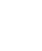

In [20]:
ROW_IMG = 10
N_ROWS = 5

fig = plt.figure()
for index in range(1, ROW_IMG * N_ROWS + 1):
    plt.subplot(N_ROWS, ROW_IMG, index)
    plt.axis('off')
    plt.imshow(test_dataset.data[index], cmap='gray_r')
    
    with torch.no_grad():
        model.eval()
        _, probs = model(test_dataset[index][0].unsqueeze(0))
        
    title = f'{torch.argmax(probs)} ({torch.max(probs * 100):.0f}%)'
    
    plt.title(title, fontsize=7)
fig.suptitle('AlexNet - predictions')

In [ ]:
test_dataset.